# UCI time series examples

In [2]:
import multiprocessing as mp
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import sys
import warnings
import os
from random import randint
from scipy.ndimage.filters import uniform_filter1d
from numpy.random import normal
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_process import arma_generate_sample
#from statsmodels.tsa.arima_model import 

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [3]:
os.getcwd()

'/Users/brunobarbarioli/Documents/Research/OTSS'

In [4]:
from algorithms.online_subsampler import *
from algorithms.analytics import *
from algorithms.breakpoint_detection import *
from algorithms.empirical_bernstein import *
from algorithms.uniform_subsampler import *
from algorithms.queries import *
from algorithms.size_optimizer import *

## Example 1 - UCI Household power consumption

https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption

In [5]:
path = '/Users/brunobarbarioli/Documents/Research/OTSS/datasets/household_power_consumption.txt'
data = pd.read_csv(path, sep = ';')

In [6]:
print(data.head(5))

         Date      Time Global_active_power Global_reactive_power  Voltage  \
0  16/12/2006  17:24:00               4.216                 0.418  234.840   
1  16/12/2006  17:25:00               5.360                 0.436  233.630   
2  16/12/2006  17:26:00               5.374                 0.498  233.290   
3  16/12/2006  17:27:00               5.388                 0.502  233.740   
4  16/12/2006  17:28:00               3.666                 0.528  235.680   

  Global_intensity Sub_metering_1 Sub_metering_2  Sub_metering_3  
0           18.400          0.000          1.000            17.0  
1           23.000          0.000          1.000            16.0  
2           23.000          0.000          2.000            17.0  
3           23.000          0.000          1.000            17.0  
4           15.800          0.000          1.000            17.0  


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [8]:
data = data[data.Sub_metering_1 != '?']
data = data[data.Sub_metering_2 != '?']
data = data[data.Sub_metering_3 != '?']

In [9]:
data.index = pd.to_datetime(data['Date'] +' '+ data['Time'])
data_clean = data.drop(columns = ['Date', 'Time'])

In [ ]:
data_clean.info()

### Sub metering 3

In [21]:
x = data_clean['Sub_metering_3']
x = x['2007-06':'2008-06']

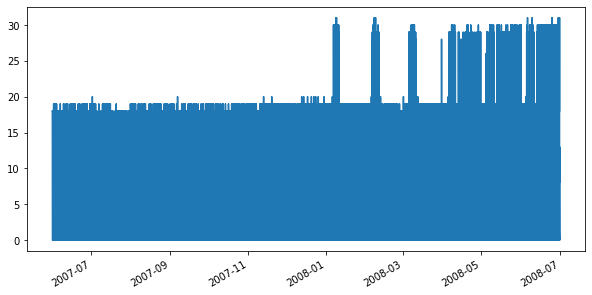

In [22]:
plt.figure(figsize=(10,5))
x.plot()

breakpoint started
subsampler started
Interval size:  454677
Relative sample size:  0.08 %
----*----
Interval size:  1577
Relative sample size:  41.22 %
----*----
Interval size:  35050
Relative sample size:  2.28 %
----*----
Interval size:  12154
Relative sample size:  6.99 %
----*----
Interval size:  6017
Relative sample size:  14.96 %
----*----
Interval size:  6580
Relative sample size:  14.44 %
----*----
Interval size:  2115
Relative sample size:  100%
----*----
Interval size:  5768
Relative sample size:  21.67 %
----*----
Interval size:  833
Relative sample size:  100%
----*----
Interval size:  3331
Relative sample size:  100%
----*----
Interval size:  18222
Relative sample size:  7.41 %
----*----
Interval size:  23726
Relative sample size:  5.69 %
----*----
Done


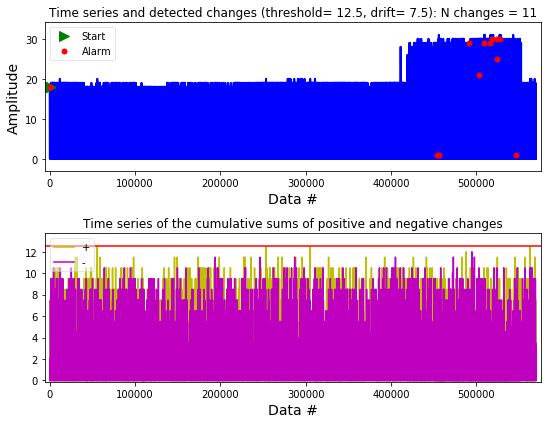

In [23]:
# Online subsampler

queue = mp.Queue()
return_queue = mp.Queue()
index_queue = mp.Queue()
p1 = mp.Process(target = detection, args = (x, queue, 12.5, 7.5, False, True))
p2 = mp.Process(target = online_subsampler, args = (0.15,0.01,20,50,x, queue, return_queue,index_queue, 1000))

p1.start()
p2.start()

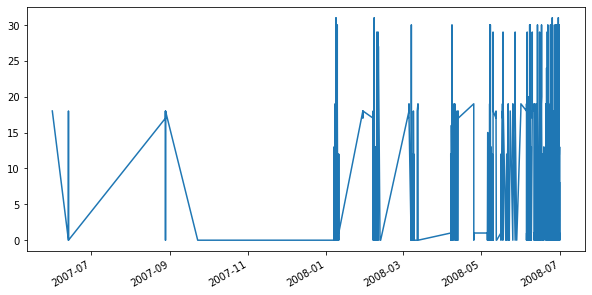

In [24]:
online_subsample = retrieve_data(return_queue)
online_subsample.plot(figsize=(10, 5))

In [ ]:
#Baseline Subsamples
online_subsample_size = len(online_subsample)
uniform_sample, eb_sample = size_optimizer(x, online_subsample_size, 10, error = 0.25)

In [ ]:
#Comparing subsample sizes
print('Online subsample size: ', online_subsample_size)
print('EB subsample size: ',len(eb_sample))
print('Uniform subsample size: ',len(uniform_sample))

In [ ]:
#upscaled subsamples
online_sample_upscaled = online_subsample.resample('D').mean()
eb_sample_upscaled = eb_sample.resample('D').mean()
uniform_sample_upscaled = uniform_sample.resample('D').mean()

In [ ]:
#interpolation querry
#10
print('Interpolation for 57th value: \n')
print('Real value: ', series[57])
print('Empirical Bernstein: ', interpolation_query(eb_sample_upscaled, 57, method = 'linear'))
print('Uniform sampler: ', interpolation_query(uniform_sample_upscaled, 57, method = 'linear'))
print('Online Sampler:', interpolation_query(online_sample_upscaled, 57, method = 'linear'))
print('------------\n')

#17400
print('Interpolation for 17400 value: \n')
print('Real value: ', series[17401])
print('Empirical Bernstein: ', interpolation_query(eb_sample_upscaled, 17401, method = 'linear'))
print('Uniform sampler: ', interpolation_query(uniform_sample_upscaled, 17401, method = 'linear'))
print('Online Sampler:', interpolation_query(online_sample_upscaled, 17401, method = 'linear'))
print('------------\n')

#1003

print('Interpolation for 1003 value: \n')
print('Real value: ', series[1003])
print('Empirical Bernstein: ', interpolation_query(eb_sample_upscaled, 1003, method = 'linear'))
print('Uniform sampler: ', interpolation_query(uniform_sample_upscaled, 1003, method = 'linear'))
print('Online Sampler:', interpolation_query(online_sample_upscaled, 1003, method = 'linear'))
print('------------\n')

#77802

print('Interpolation for 77802 value: \n')
print('Real value: ', series[77802])
print('Empirical Bernstein: ', interpolation_query(eb_sample_upscaled, 77802, method = 'linear'))
print('Uniform sampler: ', interpolation_query(uniform_sample_upscaled, 77802, method = 'linear'))
print('Online Sampler:', interpolation_query(online_sample_upscaled, 77802, method = 'linear'))
print('------------\n')

In [ ]:
# Distance metrics for linear interpolation

print('Euclidean distance: \n')
print('Empirical Bernstein: ', interpolation_distance(series, eb_sample_upscaled))
print('Uniform: ', interpolation_distance(series, uniform_sample_upscaled))
print('Online Sampler: \n', interpolation_distance(series, online_sample_upscaled))
print('------------ \n')

print('DTW distance: \n')
print('Empirical Bernstein: ', interpolation_distance(series, eb_sample_upscaled, distance = 'dtw'))
print('Uniform: ', interpolation_distance(series, uniform_sample_upscaled, distance = 'dtw'))
print('Online Sampler: \n', interpolation_distance(series, online_sample_upscaled, distance = 'dtw'))
print('------------\n')

In [ ]:
# Autocorrelation

print('Autocorrelation: \n')
print('Original time series: ')
correlation_query(series, number_of_lags = 2, print_lags = True, plot = False)
print('Empirical Bernstein: ')
correlation_query(eb_sample, number_of_lags = 2, print_lags = True, plot = False)
print('Uniform: ' )
correlation_query(uniform_sample, number_of_lags = 2, print_lags = True, plot = False)
print('Online Sampler:', )
correlation_query(online_subsample, number_of_lags = 2, print_lags = True, plot = False)
print('------------ \n')

In [ ]:
# Distance metrics for autocorrelation

print('Euclidean distance of all autocorrelation lags: \n')
print('Empirical Bernstein: ', correlation_distance(series, eb_sample, number_of_lags = 2, print_lags = False, plot = False))
print('Uniform: ', correlation_distance(series, uniform_sample, number_of_lags = 2, print_lags = False, plot = False))
print('Online Sampler: \n', correlation_distance(series, online_subsample, number_of_lags = 2, print_lags = False, plot = False))
print('------------ \n')

### Voltage

In [12]:
y = data_clean['Voltage']
y = y.astype('float')
y = y['2007-01':'2008-12']

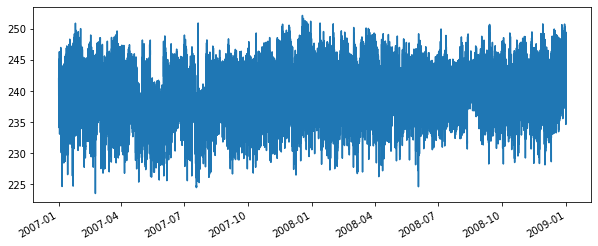

In [13]:
plt.figure(figsize=(10,4))
y.plot()